# 2D Ising Model
The 2D Ising model using the metropolis-based Monte Carlo method, as described in Fig. 8.8 Schroeder (an undergraduate statistical mechanics/thermodynamics textbook). The magnetization M, the average energy U, the heat capacity C, and the magnetic susceptibility χ are all plotted as functions of temperature. The signature discontinuity in C and χ mark the critical temperature and phase transition of the 2D spin lattice.

In [3]:
import matplotlib.pyplot as plt
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
output_notebook()

from numba import jit, njit
import numpy as np

import random
import time

Loading BokehJS ...

In [2]:
# Helper functions

# Calculate the energy of the lattice.
# The energy is the sum of interactions between spins divided by the total number of spins
@njit
def calcE(s):
    E = 0
    for i in range(width):
        for j in range(width):
            E += -deltaU(s,i,j)/2
    return E/width**2

# Calculate magnetization. 
# Magnetization is the sum of all spins divided by the total number of spins
@njit
def calcM(s):
    m = np.abs(s.sum())
    return m/width**2

# Calculate interaction energy between spins. Assume periodic boundaries
# Interaction energy will be the difference in energy due to flipping spin i,j 
# (i.e. 2*spin_value*neighboring_spins)
@njit
def deltaU(s,i,j):
    #top
    if i == 0:
        t = s[width-1,j]  # periodic boundary
    else:
        t = s[i-1,j]
    #bottom
    if i == width-1:
        b = s[0,j]  # periodic boundary
    else:
        b = s[i+1,j]
    #left
    if j == 0:
        l = s[i,width-1]  # periodic boundary
    else:
        l = s[i,j-1]
    #right
    if j == width-1:
        r = s[i,0]  # periodic boundary
    else:
        r = s[i,j+1]
    return 2*s[i,j]*(t+b+r+l)  # difference in energy if i,j is flipped

# Monte carlo cycle
@njit
def montecc(s,Temp,cycles):
    for m in range(cycles):
        i = random.randrange(width)  # choose random row
        j = random.randrange(width)  # choose random column
        ediff = deltaU(s,i,j)
        if ediff <= 0:
            s[i,j] = -s[i,j]  # flip spin
        elif random.random() < np.exp(-ediff/Temp):
            s[i,j] = -s[i,j]
    return s

# Compute physical quantities
@njit
def computePQ(s,T,cycles):
    En = 0
    En_sq = 0
    Mg = 0
    Mg_sq = 0
    for p in range(cycles):
        s = montecc(s,T,1)
        E = calcE(s)
        M = calcM(s)
        En += E
        Mg += M
        En_sq += E*E
        Mg_sq += M*M
    aveEn = En/cycles
    mag = Mg/cycles
    sus = (Mg_sq/cycles-(Mg/cycles)**2)/T
    heatCap = (En_sq/cycles-(En/cycles)**2)/(T**2)
    return aveEn, mag, sus, heatCap

In [3]:
# Initial parameters

width = 32  # width of sqaure spin lattice; 64 points may take hours
s = np.random.choice([1,-1],size=(width,width))  # initial spin sites randomly (+1 or -1)
cycles = 1000 * width**2

# Initlaize temperature range (crosses critical temperature)
temps = np.arange(1.60,3.15,0.02)

# Inititalize magnetization, average energy, heat capacity, and susceptibility
mag = np.zeros(len(temps))
aveEn = np.zeros(len(temps))
heatCap = np.zeros(len(temps))
sus = np.zeros(len(temps))

start = time.time()
# Compute physical quanities (magnetization, etc.)
for ind, T in enumerate(temps):
    # Cycle spins
    s = montecc(s,T,cycles)
    # Compute physical quanitites with 1000 cycles per spin
    aveEn[ind], mag[ind], sus[ind], heatCap[ind] = computePQ(s,T,cycles)
end = time.time()
print("Elapsed = %s" % (end - start))

Elapsed = 153.1240358352661


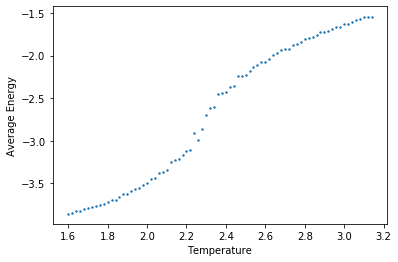

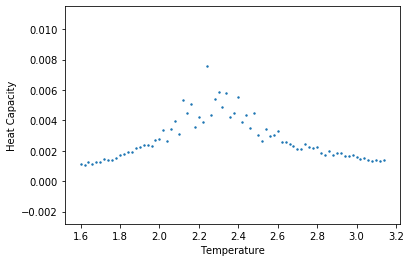

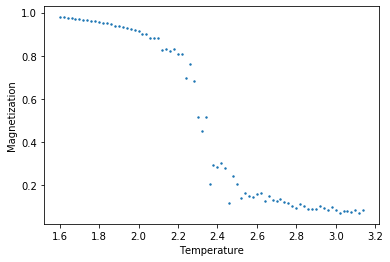

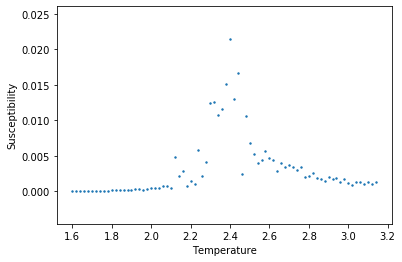

In [4]:
# Plot calculated stuff

plt.scatter(temps,aveEn,s=2)
plt.xlabel('Temperature')
plt.ylabel('Average Energy')
plt.show()

plt.scatter(temps,heatCap,s=2)
plt.xlabel('Temperature')
plt.ylabel('Heat Capacity')
plt.show()

plt.scatter(temps,mag,s=2)
plt.xlabel('Temperature')
plt.ylabel('Magnetization')
plt.show()

plt.scatter(temps,sus,s=2)
plt.xlabel('Temperature')
plt.ylabel('Susceptibility')
plt.show()

# Faster Computation
The first completed version of the code (with numba) the hyperparameters were

```width = 32
cycles = 1000 * width**2
temps = np.arange(1.60,3.15,0.02)```

and took ~ 155 seconds

Let's see what optimizations can be made! Before we look at each function, note that `x**2` takes noticably longer than `x*x` and numba offers a fastmasth option that will be incorperated in each function.

In [5]:
# Initial parameters

width = 2**5  # width of sqaure spin lattice; MUST BE POWER OF 2; 64 points may take hours
width_log2 = int(np.log2(width))
s = np.random.choice([1,-1],size=(width,width))  # initial spin sites randomly (+1 or -1)
cycles = 1000 * width**2

# Initlaize temperature range (crosses critical temperature)
temps = np.arange(1.60,3.15,0.02)

# Inititalize magnetization, average energy, heat capacity, and susceptibility
mag = np.zeros(len(temps))
aveEn = np.zeros(len(temps))
heatCap = np.zeros(len(temps))
sus = np.zeros(len(temps))

In [6]:
# old way
%timeit width**2

288 ns ± 17.9 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [7]:
# new way
%timeit width*width

65 ns ± 0.531 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


## Delta u
Is there a faster way to implement periodic boundary conditions and add up neighboring spins? An attempt using np.roll and matrix addition/mulitplication was made, but it was x20 slower.

In [8]:
# Calculate interaction energy between spins. Assume periodic boundaries. i and j and be any value
# Interaction energy will be the difference in energy due to flipping spin i,j 
# (i.e. 2*spin_value*neighboring_spins)
@njit(fastmath=True)
def deltaU_fast(s,i,j):
    #top
    if i == 0:
        t = s[width-1,j]  # periodic boundary
    else:
        t = s[i-1,j]
    #bottom
    if i == width-1:
        b = s[0,j]  # periodic boundary
    else:
        b = s[i+1,j]
    #left
    if j == 0:
        l = s[i,width-1]  # periodic boundary
    else:
        l = s[i,j-1]
    #right
    if j == width-1:
        r = s[i,0]  # periodic boundary
    else:
        r = s[i,j+1]
    return s[i,j] * (t+b+r+l)  # difference in energy if i,j is flipped

In [9]:
%timeit deltaU(s,15,15)

381 ns ± 2.45 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [10]:
%timeit deltaU_fast(s,15,15)

383 ns ± 2.83 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


%timeit reveals that `calcE()` takes up the most time. Let's start there for possible improvements.
## Calculate Energy
Using just matrix manipulations to compute the total energy took x10 longer than the the double for loop with jit. Also, having a function for the bulk spins and a function for the edge spins (in hopes of reducing if logic) actually ran slower as well. I noticed the output of `deltaU()` is multipled by 2, but then immediately divided by two in `calcE()`. Resolving this throughout the functions helped lower runtime. The two other speed ups are from `fastmath=True` and replacing `x**2` with `x*x`

In [11]:
# Calculate the energy of the lattice.
# The energy is the sum of interactions between spins divided by the total number of spins
@njit(fastmath=True)
def calcE_fast(s):
    E = 0
    for i in range(width):
        for j in range(width):
            E += -deltaU_fast(s,i,j)
    return E / (width*width)

In [12]:
# old way
%timeit calcE(s)

2.87 µs ± 94.3 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [13]:
# new way
%timeit calcE_fast(s)

1.79 µs ± 21.7 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


## Calculate Magnetization
Already fast and not a main time contributor

In [14]:
# Calculate magnetization. 
# Magnetization is the sum of all spins divided by the total number of spins
@njit(fastmath=True)
def calcM_fast(s):
    m = np.abs(s.sum()) / (width*width)
    return m

In [15]:
%timeit calcM(s)

391 ns ± 4.92 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [16]:
%timeit calcM_fast(s)

392 ns ± 2.15 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


## Monte Carlo Cycle
Overall, `montecc()` and `montecc_fast()` take the same time for one cycle, but `montecc_fast()` is noticably faster over many cycles.

### Lattice Size
If we restrict the lattice size to be a power of 2, the random number generating time deceases by a factor of 10 for that part of the computation.

In [17]:
# Monte carlo cycle
@njit(fastmath=True)
def montecc_fast(s,Temp,cycles):
    for m in range(cycles):
        i = random.getrandbits(width_log2)  # choose random row
        j = random.getrandbits(width_log2)  # choose random column
        ediff = 2 * deltaU_fast(s,i,j)
        if ediff <= 0:
            s[i,j] *= -1  # flip spin
        elif random.random() < np.exp(-ediff/Temp):
            s[i,j] *= -1
    return s

In [18]:
# old way: random number generation
%timeit random.randrange(width)

986 ns ± 3.72 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [19]:
# new way: random number generation
%timeit random.getrandbits(width_log2)

151 ns ± 0.816 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [20]:
#generate an s for testing
%timeit montecc(s,1.60,20)

1.47 µs ± 29.5 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [21]:
%timeit montecc_fast(s,1.60,20)

The slowest run took 10.30 times longer than the fastest. This could mean that an intermediate result is being cached.
3.19 µs ± 3.76 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Main computation loop
Most of the time comes from calcE function. All previously mentioned speed ups are included here.

In [22]:
# Compute physical quantities
@njit(fastmath=True)
def computePQ_fast(s,T,cycles):
    En = 0
    En_sq = 0
    Mg = 0
    Mg_sq = 0
    for p in range(cycles):
        s = montecc_fast(s,T,1)
        E = calcE_fast(s)
        M = calcM_fast(s)
        En += E
        Mg += M
        En_sq += E*E
        Mg_sq += M*M
    aveEn = En / cycles
    mag = Mg / cycles
    sus = (Mg_sq / cycles - (mag * mag))/T
    heatCap = (En_sq / cycles - (aveEn * aveEn))/(T*T)
    return aveEn, mag, sus, heatCap

In [23]:
%timeit computePQ(s,1.60,50)

94 µs ± 1.46 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [24]:
%timeit computePQ_fast(s,1.60,50)

79 µs ± 4.62 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Faster Computation
Let's use these faster functions and see how well they do! The previous computation was 155s. With the "fast" functions and same hyperparameters, it's 126s! An 18.7% faster computation!

In [25]:
# Fast helper functions all in one place

# Calculate the energy of the lattice.
# The energy is the sum of interactions between spins divided by the total number of spins
@njit(fastmath=True)
def calcE_fast(s):
    E = 0
    for i in range(width):
        for j in range(width):
            E += -deltaU_fast(s,i,j)
    return E / (width*width)


# Calculate magnetization. 
# Magnetization is the sum of all spins divided by the total number of spins
@njit(fastmath=True)
def calcM_fast(s):
    m = np.abs(s.sum()) / (width*width)
    return m

# Calculate interaction energy between spins. Assume periodic boundaries. i and j and be any value
# Interaction energy will be the difference in energy due to flipping spin i,j 
# (i.e. 2*spin_value*neighboring_spins)
@njit(fastmath=True)
def deltaU_fast(s,i,j):
    #top
    if i == 0:
        t = s[width-1,j]  # periodic boundary
    else:
        t = s[i-1,j]
    #bottom
    if i == width-1:
        b = s[0,j]  # periodic boundary
    else:
        b = s[i+1,j]
    #left
    if j == 0:
        l = s[i,width-1]  # periodic boundary
    else:
        l = s[i,j-1]
    #right
    if j == width-1:
        r = s[i,0]  # periodic boundary
    else:
        r = s[i,j+1]
    return s[i,j] * (t+b+r+l)  # difference in energy if i,j is flipped

# Monte carlo cycle
@njit(fastmath=True)
def montecc_fast(s,Temp,cycles):
    for m in range(cycles):
        i = random.getrandbits(width_log2)  # choose random row
        j = random.getrandbits(width_log2)  # choose random column
        ediff = 2 * deltaU_fast(s,i,j)
        if ediff <= 0:
            s[i,j] *= -1  # flip spin
        elif random.random() < np.exp(-ediff/Temp):
            s[i,j] *= -1
    return s


# Compute physical quantities
@njit(fastmath=True)
def computePQ_fast(s,T,cycles):
    En = 0
    En_sq = 0
    Mg = 0
    Mg_sq = 0
    for p in range(cycles):
        s = montecc_fast(s,T,1)
        E = calcE_fast(s)
        M = calcM_fast(s)
        En += E
        Mg += M
        En_sq += E*E
        Mg_sq += M*M
    aveEn = En / cycles
    mag = Mg / cycles
    sus = (Mg_sq / cycles - (mag * mag))/T
    heatCap = (En_sq / cycles - (aveEn * aveEn))/(T*T)
    return aveEn, mag, sus, heatCap

In [26]:
start = time.time()
# Compute physical quanities (magnetization, etc.)
for ind, T in enumerate(temps):
    # Cycle spins
    s = montecc_fast(s,T,cycles)
    # Compute physical quanitites with 1000 cycles per spin
    aveEn[ind], mag[ind], sus[ind], heatCap[ind] = computePQ_fast(s,T,cycles)
end = time.time()
print("Elapsed = %s" % (end - start))

Elapsed = 126.50802516937256


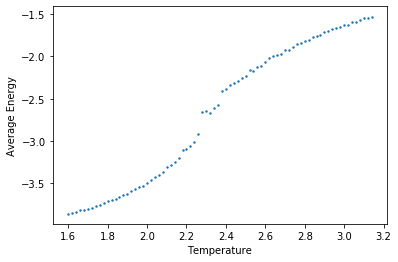

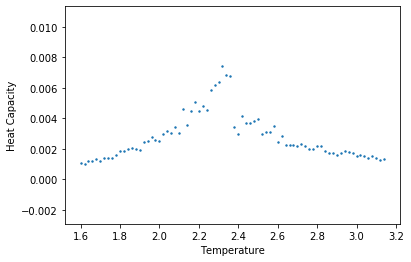

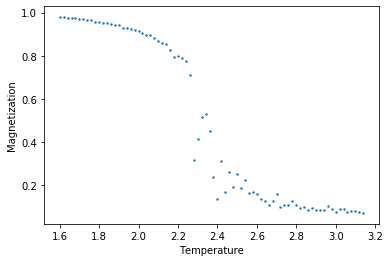

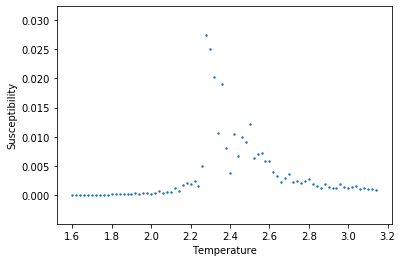

In [27]:
# Plot calculated stuff

plt.scatter(temps,aveEn,s=2)
plt.xlabel('Temperature')
plt.ylabel('Average Energy')
plt.show()

plt.scatter(temps,heatCap,s=2)
plt.xlabel('Temperature')
plt.ylabel('Heat Capacity')
plt.show()

plt.scatter(temps,mag,s=2)
plt.xlabel('Temperature')
plt.ylabel('Magnetization')
plt.show()

plt.scatter(temps,sus,s=2)
plt.xlabel('Temperature')
plt.ylabel('Susceptibility')
plt.show()

In [4]:
# Reduced helper functions

# Calculate magnetization. 
# Magnetization is the sum of all spins divided by the total number of spins
@njit(fastmath=True)
def calcM(s, width):
    m = np.abs(s.sum())
    return m/(width**2)

# Calculate interaction energy between spins. Assume periodic boundaries
# Interaction energy will be the difference in energy due to flipping spin i,j 
# (i.e. 2*spin_value*neighboring_spins)
@njit(fastmath=True)
def deltaU(s, i, j, width):
    #top
    if i == 0:
        t = s[width-1,j]  # periodic boundary
    else:
        t = s[i-1,j]
    #bottom
    if i == width-1:
        b = s[0,j]  # periodic boundary
    else:
        b = s[i+1,j]
    #left
    if j == 0:
        l = s[i,width-1]  # periodic boundary
    else:
        l = s[i,j-1]
    #right
    if j == width-1:
        r = s[i,0]  # periodic boundary
    else:
        r = s[i,j+1]
    return 2*s[i,j]*(t+b+r+l)  # difference in energy if i,j is flipped

# Monte carlo cycle
@njit(fastmath=True)
def montecc(s, T, cycles, width):
    for m in range(cycles):
        i = random.randrange(width)  # choose random row
        j = random.randrange(width)  # choose random column
        ediff = deltaU(s, i, j, width)
        if ediff <= 0:
            s[i,j] = -s[i,j]  # flip spin
        elif random.random() < np.exp(-ediff/T):
            s[i,j] = -s[i,j]
    return s

# Compute physical quantities
@njit(fastmath=True)
def computePQ(s, T, cycles, width):
    Mg = 0
    Mg_sq = 0
    for p in range(cycles):
        s = montecc(s, T, 1, width)
        M = calcM(s, width)
        Mg += M
        Mg_sq += M*M
    sus = (Mg_sq/cycles-(Mg/cycles)**2)/T
    return sus

In [5]:
# Initial parameters

width = 16  # width of sqaure spin lattice; 64 points may take hours
s = np.random.choice([1,-1], size=(width, width))  # initial spin sites randomly (+1 or -1)
cycles = 3000000

# Initlaize temperature range (crosses critical temperature)
temps = np.arange(1.9, 3.2, 0.04)

# Inititalize magnetization, average energy, heat capacity, and susceptibility
sus_16 = np.zeros(len(temps))

start = time.time()
# Compute physical quanities (magnetization, etc.)
for ind, T in enumerate(temps):
    # Cycle spins
    s = montecc(s, T, cycles, width)
    sus_16[ind] = computePQ(s, T, cycles, width)
end = time.time()
print("Elapsed = %s" % (end - start))

Elapsed = 20.1909019947052


In [7]:
# Initial parameters

width = 32  # width of sqaure spin lattice; 64 points may take hours
s = np.random.choice([1,-1], size=(width, width))  # initial spin sites randomly (+1 or -1)

# Inititalize magnetization, average energy, heat capacity, and susceptibility
sus_32 = np.zeros(len(temps))

start = time.time()
# Compute physical quanities (magnetization, etc.)
for ind, T in enumerate(temps):
    # Cycle spins
    s = montecc(s, T, cycles, width)
    sus_32[ind] = computePQ(s, T, cycles, width)
end = time.time()
print("Elapsed = %s" % (end - start))

Elapsed = 23.322134017944336


In [8]:
# Initial parameters

width = 64  # width of sqaure spin lattice; 64 points may take hours
s = np.random.choice([1,-1], size=(width, width))  # initial spin sites randomly (+1 or -1)

# Inititalize magnetization, average energy, heat capacity, and susceptibility
sus_64 = np.zeros(len(temps))

start = time.time()
# Compute physical quanities (magnetization, etc.)
for ind, T in enumerate(temps):
    # Cycle spins
    s = montecc(s, T, cycles, width)
    sus_64[ind] = computePQ(s, T, cycles, width)
end = time.time()
print("Elapsed = %s" % (end - start))

Elapsed = 47.70257210731506


In [28]:
nu = 1
eta = 2.5
tc = 2.35
t = (temps-tc)/tc
x16 = t * (16**2)**(1/nu)
y16 = sus_16 * (16**2)**(eta - 2)
x32 = t * (32**2)**(1/nu)
y32 = sus_32 * (32**2)**(eta - 2)
x64 = t * (64**2)**(1/nu)
y64 = sus_64 * (64**2)**(eta - 2)

#Interactive plot
p = figure(plot_width=700, plot_height=350)
p.line(x16, y16, color='red')
p.line(x32, y32, color='blue')
p.line(x64, y64, color='brown')
show(p)

In [10]:
# Plot calculated stuff

p = figure(plot_width=600, plot_height=400)
p.scatter(temps, sus_16, color='red')
p.scatter(temps, sus_32, color='blue')
p.scatter(temps, sus_64, color='brown')

show(p)